<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">BE - ML</div>

# Introduction

Unmanned Aerial Vehicles (UAVs), commonly known as drones, are increasingly being deployed for applications such as surveillance, delivery, environmental monitoring, and disaster management. However, the growing reliance on UAVs also exposes them to significant **cybersecurity risks**, as malicious actors can exploit vulnerabilities in their communication and control systems. To address this challenge, **intrusion detection systems (IDSs)** leveraging machine learning have become an active area of research.

This project utilizes the **Cyber-Physical Dataset for UAVs Under Normal Operations and Cyberattacks**, developed by **Hassler, Mughal, and Ismail (2023)**. The dataset captures both **cyber and physical telemetry data** from UAVs under normal flight conditions and during four distinct types of cyberattacks:

1. **De-authentication Denial-of-Service (DoS) attack**
2. **Replay attack**
3. **False Data Injection (FDI) attack**
4. **Evil Twin attack**

The dataset is composed of two major components:

* **Cyber dataset** containing 37 features that describe network-level parameters and communication behavior.
* **Physical dataset** containing 16 features that represent UAV motion dynamics such as altitude, velocity, position, and orientation.

Each record in the dataset corresponds to either **benign (normal)** operation or one of the aforementioned **attack scenarios**, making it suitable for **binary (normal vs. malicious)** or **multi-class** classification tasks. The data were collected using a custom UAV testbed with real-time attack emulation and monitoring tools.


**Reference:**
Hassler, S. C., Mughal, U. A., & Ismail, M. (2023). *Cyber-Physical Intrusion Detection System for Unmanned Aerial Vehicles*. IEEE Transactions on Intelligent Transportation Systems.
Available via GitHub: [https://github.com/uamughal/UAVs-Dataset-Under-Normal-and-Cyberattacks](https://github.com/uamughal/UAVs-Dataset-Under-Normal-and-Cyberattacks)




## Project Objective

In this notebook, we aim to design and evaluate intelligent **cyber-physical intrusion detection systems (IDS)** capable of detecting abnormal UAV behaviors in real time.
To achieve this, the problem is approached in **two complementary ways**:

### 1. **Supervised Classification**

In this first stage, the task is treated as a standard **supervised learning problem** where each observation is labeled as *benign* or *malicious*.
We train and compare two widely used machine learning algorithms:

* **Support Vector Machine (SVM)** — a robust classifier that finds optimal separating hyperplanes.
* **Random Forest (RF)** — an ensemble method that combines multiple decision trees to improve generalization and interpretability.

These models are evaluated in terms of precision, recall, and F1-score across different datasets (Cyber, Physical, and Cyber-Physical).

### 2. **Unsupervised Anomaly Detection**

In the second stage, the problem is reformulated as an **anomaly detection task**, simulating a real-world scenario where labeled attack data may not be available.
We explore two learning paradigms:

* **Outlier Detection**, where models are trained directly on the mixed dataset (benign + attack) to identify deviations.
* **Novelty Detection**, where models are trained only on benign samples and tested on unseen (potentially malicious) data.

Two state-of-the-art algorithms are used:

* **Isolation Forest (IF)** — based on the principle of isolating anomalies using random partitions.
* **Local Outlier Factor (LOF)** — identifies local density deviations of data points relative to their neighbors.

By comparing these two detection strategies, we highlight the trade-offs between supervised classification and unsupervised anomaly detection in developing effective UAV intrusion detection systems.

# partie Colin

[1.         0.99518845 0.99759423 0.99919808 1.        ]


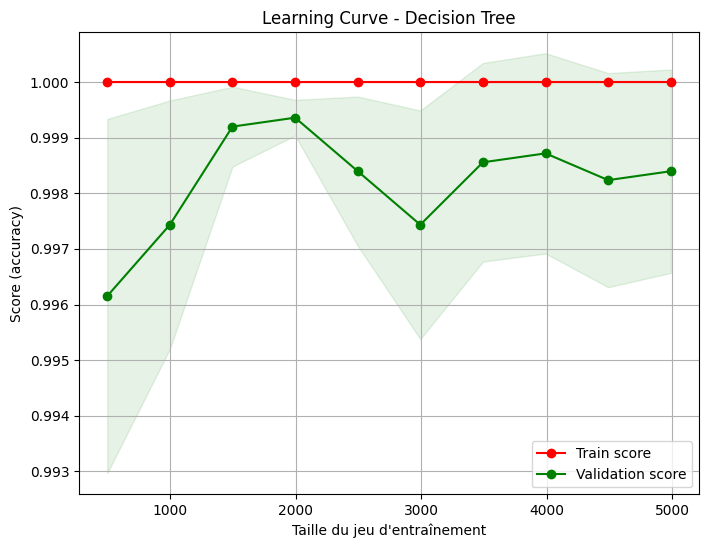

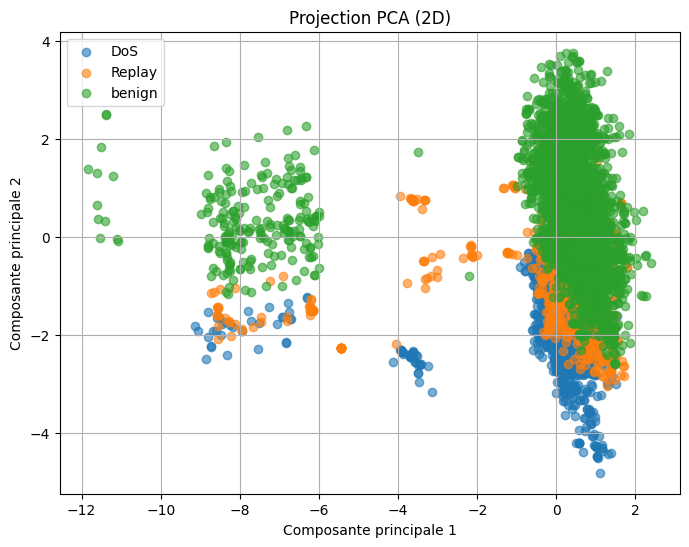

Variance expliquée par composante : [0.21937489 0.12786732]


In [1]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import learning_curve

# === Chargement des données ===
data_Physical = pd.read_csv('Data/Merged_Physical.csv')
X_physical = data_Physical.drop(columns=['class'])
y_physical = data_Physical['class']

data_Cyber = pd.read_csv('Data/Merged_Cyber.csv')
X_cyber = data_Cyber.drop(columns=['class'])
y_cyber = data_Cyber['class']

# === Choisir le dataset à utiliser ===
X = X_physical
y = y_physical
# X = X_cyber
# y = y_cyber

# === 0. Mélange aléatoire (shuffle) ===
X, y = shuffle(X, y, random_state=42)

# === 1. Pipeline : normalisation + modèle === Découpage K-Fold train/test
model = make_pipeline(StandardScaler(), DecisionTreeClassifier(criterion = 'entropy'))

# === 2. Découpage train/test : méthode K-Fold ===
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)

# === 4. Évaluation ===
scores = cross_val_score(model, X, y, cv=kf5)
print(scores)

# === 3️⃣ Calculer les learning curves ===
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X,
    y=y,
    cv=kf5,                  # 5-fold cross-validation
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 points de 10% à 100% des données
    scoring='accuracy',
    random_state=42
)

# === 4️⃣ Calculer les moyennes et écarts-types ===
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# === 5️⃣ Tracer les courbes ===
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Train score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validation score")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, color="g", alpha=0.1)

plt.title("Learning Curve - Decision Tree")
plt.xlabel("Taille du jeu d'entraînement")
plt.ylabel("Score (accuracy)")
plt.legend(loc="best")
plt.grid(True)
plt.show()


# === Standardiser les données ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# === Appliquer la PCA ===
pca = PCA(n_components=2)   # On garde 2 composantes pour visualiser
X_pca = pca.fit_transform(X_scaled)
# === Visualisation ===
labels = np.unique(y)
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    plt.scatter(X_pca[y==label, 0], X_pca[y==label, 1], label=label, alpha=0.6)

plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Projection PCA (2D)')
plt.legend()
plt.grid(True)
plt.show()

print("Variance expliquée par composante :", pca.explained_variance_ratio_)


Méthode XGBoost 

Scores: [1.         0.99839615 0.99919808 0.99839615 1.        ]
Mean: 0.9991980753809141
Standard Deviation: 0.0007172631844425825


<Axes: xlabel='Feature'>

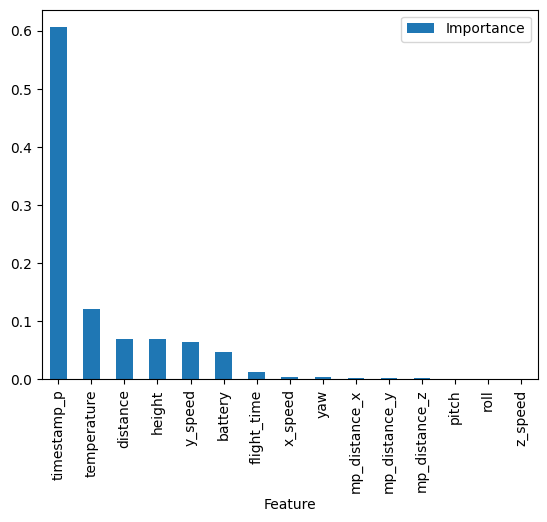

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

xgb = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb, X, y_encoded, cv=kf5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())


X.drop(columns=['barometer'], inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 2. Découpage train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
xgb.fit(X_train, y_train)

importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')

importances.plot.bar()

# partie Mohamed

### **Imports**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import plotly.graph_objects as go
import plotly.express as px
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import copy


### **Data acquisation**

#### Data Extraction

In this step, we extract and clean the raw UAV dataset from the original combined CSV file. Each attack type and data modality (Cyber or Physical) is separated into individual CSV files based on predefined row ranges. During this process, we detect and apply proper headers, remove empty or irrelevant columns, and save the cleaned subsets to the output directory for further analysis

In [ ]:
# === CONFIGURATION ===
csv_path = "Dataset_T-ITS.csv"     # your original file
output_dir = "Data"
os.makedirs(output_dir, exist_ok=True)

# === Definition of ranges (1-based, inclusive) ===
ranges = {
    "Benign":       {"Cyber": (1, 9426),     "Physical": (9427, 13717)},
    "DoS Attack":   {"Cyber": (13718, 25389),"Physical": (25390, 26363)},
    "Replay Attack":{"Cyber": (26364, 38370),"Physical": (38371, 39344)},
    "Evil Twin":    {"Cyber": (39345, 45028),"Physical": (45029, 50502)},
    "FDI":          {"Cyber": (50503, 53976),"Physical": (53977, 54784)}
}

# === READ WITHOUT HEADER ===
df_raw = pd.read_csv(csv_path, header=None)
n = len(df_raw)
print(f"📂 File loaded ({n} rows)\n")

# === HEADER DETECTION FUNCTION BY KEYWORD ===
def is_header_line(row):
    return row.astype(str).str.contains("class", case=False, na=False).any()

# === EXTRACTION OF BLOCKS ACCORDING TO RANGES ===
for attack, parts in ranges.items():
    for part_name, (start, end) in parts.items():
        start_idx = max(0, start - 1)
        end_idx = min(n, end)
        sub_df = df_raw.iloc[start_idx:end_idx].copy()

        # Find the header line inside the block
        header_idx = sub_df.index[sub_df.apply(is_header_line, axis=1)]
        if len(header_idx) == 0:
            print(f"⚠️ No header found in {attack} - {part_name} ({start}-{end}), skipped.")
            continue

        header_row = header_idx[0]
        header = sub_df.loc[header_row]

        # Remove lines before the header
        sub_df = sub_df.loc[header_row + 1:]
        sub_df.columns = header
        sub_df.reset_index(drop=True, inplace=True)

        # === 🔹 CLEAN EMPTY COLUMNS ===
        # Remove columns that are entirely empty
        sub_df = sub_df.dropna(axis=1, how='all')

        # Remove columns with empty or undefined names
        sub_df = sub_df.loc[:, [str(c).strip() not in ["", "Unnamed: 0", "Unnamed: 1", "nan"] for c in sub_df.columns]]

        # Remove columns where all values are NaN or just empty commas
        sub_df = sub_df.loc[:, sub_df.apply(lambda col: not all(str(x).strip() in ["", "nan"] for x in col), axis=0)]

        # Count number of valid features
        valid_features = [c for c in sub_df.columns if pd.notna(c) and str(c).strip() != ""]
        n_features = len(valid_features)

        # Save the cleaned block
        filename = f"{attack.replace(' ', '_')}_{part_name}.csv"
        path_out = os.path.join(output_dir, filename)
        sub_df.to_csv(path_out, index=False)

        # Final display
        print(f"✅ {attack} ({part_name}): {len(sub_df)} rows, {n_features} features")

print("\n🎯 Done: all blocks have been extracted and cleaned.")


**Comment:**
As observed, the *Evil Twin* and *FDI* attack datasets (for both physical and cyber domains) contain a different number of features compared to the other classes, and their feature names also vary. Upon reviewing the original GitHub repository, several users noted that these subsets likely originate from a different research study. To ensure homogeneity and consistency across the dataset, we decided to **exclude the Evil Twin and FDI attacks (both physical and cyber)** from our analysis.

#### Data Loading

The merging process combines the physical and cyber datasets based on synchronized timestamps and matching class labels, ensuring a unified cyber-physical dataset suitable for integrated UAV system analysis. As a result, we will create three datasets — Physical, Cyber, and Cyber-Physical — each containing three classes: Benign, DoS Attack, and Replay Attack.

In [ ]:
# =====================================================
#            UAVs Dataset Merge Utility
# =====================================================
# Combines:
#   1️⃣ Physical data files
#   2️⃣ Cyber data files
#   3️⃣ Merges both into Cyber-Physical dataset
# =====================================================

import os
import pandas as pd

# ---------------- CONFIGURATION ----------------
DATA_DIR = "Data"
OUTPUTS = {
    "physical": os.path.join(DATA_DIR, "Merged_Physical.csv"),
    "cyber": os.path.join(DATA_DIR, "Merged_Cyber.csv"),
    "cp": os.path.join(DATA_DIR, "Merged_CP.csv"),
}

PHYSICAL_FILES = [
    "Benign_Physical.csv",
    "DoS_Attack_Physical.csv",
    "Replay_Attack_Physical.csv",
]

CYBER_FILES = [
    "Benign_Cyber.csv",
    "DoS_Attack_Cyber.csv",
    "Replay_Attack_Cyber.csv",
]

# ---------------- UTILITIES ----------------
def check_files_exist(files):
    """Ensure all files exist before processing."""
    for f in files:
        if not os.path.exists(f):
            raise FileNotFoundError(f"❌ File not found: {f}")

def clean_csv(df):
    """Remove repeated headers and empty rows."""
    df = df[~df.iloc[:, 0].astype(str).str.contains("class|timestamp", case=False, na=False)]
    return df.dropna(how="all").reset_index(drop=True)

def merge_csv_files(file_list, output_path):
    """Read, clean, and vertically concatenate multiple CSVs."""
    check_files_exist(file_list)

    dfs = []
    for i, f in enumerate(file_list):
        df = pd.read_csv(f)
        df = clean_csv(df)
        if i > 0:
            df.columns = dfs[0].columns  # align column names
        dfs.append(df)

    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.to_csv(output_path, index=False)
    print(f"✅ Merged {len(file_list)} files -> {output_path}")
    print(f"   {len(merged_df)} rows, {len(merged_df.columns)} columns\n")
    return merged_df

def normalize_class(c):
    """Standardize class labels."""
    c = str(c).strip().lower()
    if "dos" in c:
        return "dos"
    elif "replay" in c:
        return "replay"
    elif "benign" in c:
        return "benign"
    else:
        return c

def merge_cyber_physical(df_phys, df_cyber, output_path):
    """Synchronize and merge physical and cyber datasets."""
    # Check timestamps
    if "timestamp_p" not in df_phys.columns or "timestamp_c" not in df_cyber.columns:
        raise KeyError("❌ Columns 'timestamp_p' or 'timestamp_c' are missing.")

    # Rename for alignment
    df_phys = df_phys.rename(columns={"timestamp_p": "timestamp"})
    df_cyber = df_cyber.rename(columns={"timestamp_c": "timestamp"})

    # Check 'class' column
    if "class" not in df_phys.columns or "class" not in df_cyber.columns:
        raise KeyError("❌ Both files must contain a 'class' column.")

    # Normalize classes
    df_phys["class"] = df_phys["class"].apply(normalize_class)
    df_cyber["class"] = df_cyber["class"].apply(normalize_class)

    # Keep only common classes
    common_classes = set(df_phys["class"]) & set(df_cyber["class"])
    df_phys = df_phys[df_phys["class"].isin(common_classes)]
    df_cyber = df_cyber[df_cyber["class"].isin(common_classes)]
    print(f"✅ Common classes: {common_classes}")

    # Sort and merge
    df_phys = df_phys.sort_values("timestamp")
    df_cyber = df_cyber.sort_values("timestamp")

    df_merged = pd.merge_asof(
        df_phys,
        df_cyber,
        on="timestamp",
        by="class",
        direction="backward"
    ).dropna(how="all").reset_index(drop=True)

    # Move 'class' to the end
    if "class" in df_merged.columns:
        cols = [c for c in df_merged.columns if c != "class"] + ["class"]
        df_merged = df_merged[cols]

    df_merged.to_csv(output_path, index=False)
    print(f"✅ Cyber-Physical merged -> {output_path}")
    print(f"   {len(df_merged)} rows, {len(df_merged.columns)} columns\n")
    return df_merged

# ---------------- MAIN PIPELINE ----------------
def main():
    print("🚀 Starting UAV Dataset Merge Pipeline\n")

    # 1️⃣ Merge Physical
    phys_paths = [os.path.join(DATA_DIR, f) for f in PHYSICAL_FILES]
    df_phys = merge_csv_files(phys_paths, OUTPUTS["physical"])

    # 2️⃣ Merge Cyber
    cyber_paths = [os.path.join(DATA_DIR, f) for f in CYBER_FILES]
    df_cyber = merge_csv_files(cyber_paths, OUTPUTS["cyber"])

    # 3️⃣ Merge Cyber + Physical
    df_phys = pd.read_csv(OUTPUTS["physical"])
    df_cyber = pd.read_csv(OUTPUTS["cyber"])
    merge_cyber_physical(df_phys, df_cyber, OUTPUTS["cp"])

    print("🎯 All merges completed successfully.")

# ---------------- EXECUTION ----------------
if __name__ == "__main__":
    os.makedirs(DATA_DIR, exist_ok=True)
    main()


### **Data exploration**

In [ ]:
# === LOAD DATASETS ===
data_Cyber = pd.read_csv("Data/Merged_Cyber.csv")
data_Physical = pd.read_csv("Data/Merged_Physical.csv")
data_CP = pd.read_csv("Data/Merged_CP.csv")

In [ ]:
data_Cyber.describe()

In [ ]:
data_Physical.describe()

In [ ]:
data_CP.describe()

In [ ]:
# =====================================================
#          UAVs Dataset — Exploratory Visualization
# =====================================================
# Plots the top 2 most important features for each dataset:
#   - Cyber:      time_since_last_packet vs wlan.seq
#   - Physical:   battery vs temperature
#   - Cyber-Phys: battery (physical) vs wlan.seq (cyber)
# =====================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ---------------- CONFIGURATION ----------------
DATA_DIR = "Data"
DATASETS = {
    "Cyber": os.path.join(DATA_DIR, "Merged_Cyber.csv"),
    "Physical": os.path.join(DATA_DIR, "Merged_Physical.csv"),
    "Cyber-Physical": os.path.join(DATA_DIR, "Merged_CP.csv"),
}

TOP_FEATURES = {
    "Cyber": ["time_since_last_packet", "wlan.seq"],
    "Physical": ["temperature", "temperature"],
    "Cyber-Physical": ["temperature", "wlan.seq"],  # physical + cyber
}

PALETTE = {"benign": "#66c2a5", "dos": "#fc8d62", "replay": "#8da0cb"}

# ---------------- LOAD AND PLOT ----------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, path) in zip(axes, DATASETS.items()):
    df = pd.read_csv(path)

    # Normalize class names (important!)
    df["class"] = (
        df["class"]
        .astype(str)
        .str.lower()
        .str.strip()
        .str.replace("attack", "", regex=False)
        .str.strip()
    )

    f1, f2 = TOP_FEATURES[name]
    if f1 not in df.columns or f2 not in df.columns:
        print(f"⚠️ Skipping {name}: missing features {f1}, {f2}")
        continue

    sns.scatterplot(
        data=df,
        x=f1,
        y=f2,
        hue="class",
        palette=PALETTE,
        s=20,
        alpha=0.7,
        ax=ax,
    )

    ax.set_title(f"{name} Dataset — {f1} vs {f2}")
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.grid(alpha=0.3)
    ax.legend(title="Class", loc="best")

plt.suptitle("Top 2 Important Features — Scatter Plot by Dataset", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()


In [ ]:
# === Create Subplots ===
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
fig.suptitle("Distribution of wlan.seq for Each Class (Cyber Dataset)", fontsize=14)

# === Histogram for Benign ===
sns.histplot(
    data=data_Cyber[data_Cyber["class"] == "benign"]["wlan.seq"],
    bins=30,
    ax=axes[0],
    kde=False,
    color="#66c2a5"
)
axes[0].set_title("Benign")
axes[0].set_xlabel("wlan.seq")
axes[0].set_ylabel("Frequency")

# === Histogram for DoS Attack ===
sns.histplot(
    data=data_Cyber[data_Cyber["class"].str.lower().str.contains("dos")]["wlan.seq"],
    bins=30,
    ax=axes[1],
    kde=False,
    color="#fc8d62"
)
axes[1].set_title("DoS Attack")
axes[1].set_xlabel("wlan.seq")
axes[1].set_ylabel("Frequency")

# === Histogram for Replay Attack ===
sns.histplot(
    data=data_Cyber[data_Cyber["class"].str.lower().str.contains("replay")]["wlan.seq"],
    bins=30,
    ax=axes[2],
    kde=False,
    color="#8da0cb"
)
axes[2].set_title("Replay Attack")
axes[2].set_xlabel("wlan.seq")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
# === Create Subplots ===
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
fig.suptitle("Distribution of Flight Time for Each Class (Physical Dataset)", fontsize=14)

# === Histogram for Benign ===
sns.histplot(
    data=data_Physical[data_Physical["class"] == "benign"]["temperature"],
    bins=30,
    ax=axes[0],
    kde=False,
    color="#66c2a5"
)
axes[0].set_title("Benign")
axes[0].set_xlabel("Flight Time")
axes[0].set_ylabel("temperature")

# === Histogram for DoS Attack ===
sns.histplot(
    data=data_Physical[data_Physical["class"].str.lower().str.contains("dos")]["temperature"],
    bins=30,
    ax=axes[1],
    kde=False,
    color="#fc8d62"
)
axes[1].set_title("DoS Attack")
axes[1].set_xlabel("temperature")
axes[1].set_ylabel("Frequency")

# === Histogram for Replay Attack ===
sns.histplot(
    data=data_Physical[data_Physical["class"].str.lower().str.contains("replay")]["temperature"],
    bins=30,
    ax=axes[2],
    kde=False,
    color="#8da0cb"
)
axes[2].set_title("Replay Attack")
axes[2].set_xlabel("temperature")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


#### Class Distribution Visualization for Cyber , Physical and Cyber-Physical Data

In [ ]:
# === IMPORTS ===
import matplotlib.pyplot as plt
import pandas as pd
# === COLUMN VERIFICATION ===
for name, df in [("Cyber", data_Cyber), ("Physical", data_Physical), ("Cyber-Physical", data_CP)]:
    if "class" not in df.columns:
        raise KeyError(f"❌ The 'class' column is missing in {name}")

# === NORMALIZE CLASS LABELS ===
def normalize_labels(y):
    """Standardize class names for consistent plotting."""
    return (
        y.astype(str)
         .str.lower()
         .replace(r"\s+", "", regex=True)
         .replace({
             "dosattack": "dos",
             "dos_attack": "dos",
             "dos": "dos",
             "attackdos": "dos",
             "replay": "replay",
             "replayattack": "replay",
             "replay_attack": "replay",
             "attackreplay": "replay",
             "benign": "benign"
         })
    )

data_Cyber["class"] = normalize_labels(data_Cyber["class"])
data_Physical["class"] = normalize_labels(data_Physical["class"])
data_CP["class"] = normalize_labels(data_CP["class"])

# === CLASS COUNTS ===
class_counts_cyber = data_Cyber["class"].value_counts()
class_counts_physical = data_Physical["class"].value_counts()
class_counts_cp = data_CP["class"].value_counts()

# === FIXED COLOR MAP (same order for all) ===
class_colors = {
    "benign": "#66c2a5",   # greenish
    "dos": "#fc8d62",      # orange
    "replay": "#8da0cb"    # bluish
}

# === Function to get colors in class order ===
def get_colors(labels):
    return [class_colors.get(lbl, "#cccccc") for lbl in labels]

# === CREATE SUBPLOTS (1 row, 3 columns) ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# --- Pie chart: Cyber ---
axes[0].pie(
    class_counts_cyber,
    labels=class_counts_cyber.index,
    colors=get_colors(class_counts_cyber.index),
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
axes[0].set_title("Class Distribution — Cyber Data")

# --- Pie chart: Physical ---
axes[1].pie(
    class_counts_physical,
    labels=class_counts_physical.index,
    colors=get_colors(class_counts_physical.index),
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
axes[1].set_title("Class Distribution — Physical Data")

# --- Pie chart: Cyber-Physical ---
axes[2].pie(
    class_counts_cp,
    labels=class_counts_cp.index,
    colors=get_colors(class_counts_cp.index),
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
axes[2].set_title("Class Distribution — Cyber-Physical Data")

# === GLOBAL LEGEND ===
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=cls.capitalize(),
               markerfacecolor=color, markersize=10)
    for cls, color in class_colors.items()
]
fig.legend(handles=handles, loc='lower center', ncol=3, title="Class")

# === ADJUSTMENTS ===
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


### **Feature Engineering**

In this step, we performed standardized preprocessing and feature engineering across all UAV datasets. We removed irrelevant or redundant columns (such as timestamps), normalized the class labels to ensure consistent naming across datasets, and applied Min–Max scaling to rescale all features between 0 and 1. This allows us to obtain homogeneous feature distributions and avoid scale-related bias in our subsequent modeling

In [ ]:
# === CONFIGURATION ===
input_dir = "Data"
files = {
    "Physical": f"{input_dir}/Merged_Physical.csv",
    "Cyber": f"{input_dir}/Merged_Cyber.csv",
    "CyberPhysical": f"{input_dir}/Merged_CP.csv"
}

# === FUNCTION TO NORMALIZE CLASS LABELS ===
def normalize_class_labels(y):
    """
    Normalize all class names across datasets:
    - lowercase
    - remove spaces
    - unify naming variants (dos, replay, benign)
    """
    return (
        y.astype(str)
         .str.lower()
         .replace(r"\s+", "", regex=True)
         .replace({
             "dosattack": "dos",
             "dos_attack": "dos",
             "dos": "dos",
             "attackdos": "dos",
             "replay": "replay",
             "replayattack": "replay",
             "replay_attack": "replay",
             "attackreplay": "replay",
             "benign": "benign"
         })
    )

# === COLUMNS TO DROP PER DATASET TYPE ===
drop_map = {
    "Physical": ['class', 'timestamp_p', 'barometer'],
    "Cyber": ['class', 'timestamp_c', 'frame.number'],
    "CyberPhysical": ['class', 'timestamp', 'frame.number', 'barometer']
}

# === PROCESSING PIPELINE ===
processed_data = {}

for name, path in files.items():
    print(f"\n📂 Loading {name} dataset ...")
    df = pd.read_csv(path)
    print(f"   → {df.shape[0]} rows, {df.shape[1]} columns")

    # Drop irrelevant columns safely
    X = df.drop(columns=[c for c in drop_map[name] if c in df.columns], errors='ignore')

    # Normalize class labels
    y = normalize_class_labels(df['class'])

    # Shuffle (break temporal dependence)
    X, y = shuffle(X, y, random_state=42)

    # Min-Max scaling
    scaler = MinMaxScaler() 
    #scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    processed_data[name] = {
        "X": X,
        "y": y,
        "X_scaled": X_scaled,
        "scaler": scaler
    }

    print(f"   ✅ Processed: {X.shape[0]} samples, {X.shape[1]} features")

# === SUMMARY OF NORMALIZED CLASS DISTRIBUTIONS ===
print("\n=== 📊 Normalized Class Distributions ===")
for name, data in processed_data.items():
    counts = data["y"].value_counts().to_dict()
    print(f"{name:15s} → {counts}")

# === EXTRACT VARIABLES FOR MODELING ===
X_physical, X_physical_scaled, y_physical = (
    processed_data["Physical"]["X"],
    processed_data["Physical"]["X_scaled"],
    processed_data["Physical"]["y"]
)

X_cyber, X_cyber_scaled, y_cyber = (
    processed_data["Cyber"]["X"],
    processed_data["Cyber"]["X_scaled"],
    processed_data["Cyber"]["y"]
)

X_cp, X_cp_scaled, y_cp = (
    processed_data["CyberPhysical"]["X"],
    processed_data["CyberPhysical"]["X_scaled"],
    processed_data["CyberPhysical"]["y"]
)

print("\n✅ All datasets successfully loaded and preprocessed!")
print(f"Physical: X={X_physical.shape}, y={y_physical.shape}")
print(f"Cyber:    X={X_cyber.shape}, y={y_cyber.shape}")
print(f"Cyber-Physical: X={X_cp.shape}, y={y_cp.shape}")


### **Machine Learning Models - Training**

#### Principal Component Analysis

In [ ]:
# === 1️⃣ PCA FIT ===
pca_cyber = PCA().fit(X_cyber_scaled)
pca_physical = PCA().fit(X_physical_scaled)
pca_cp = PCA().fit(X_cp_scaled)

# === 2️⃣ Cumulative Explained Variance ===
var_cum_cyber = np.cumsum(pca_cyber.explained_variance_ratio_)
var_cum_physical = np.cumsum(pca_physical.explained_variance_ratio_)
var_cum_cp = np.cumsum(pca_cp.explained_variance_ratio_)

# === 3️⃣ Plot cumulative variance (3 side-by-side graphs) ===
plt.figure(figsize=(18, 5))

# ---- Plot 1: Cyber Dataset ----
plt.subplot(1, 3, 1)
plt.plot(var_cum_cyber, marker='o', color='blue')
plt.title("PCA - Cyber Dataset")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.ylim(0, 1.05)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()

# ---- Plot 2: Physical Dataset ----
plt.subplot(1, 3, 2)
plt.plot(var_cum_physical, marker='o', color='orange')
plt.title("PCA - Physical Dataset")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.ylim(0, 1.05)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()

# ---- Plot 3: Cyber-Physical Dataset ----
plt.subplot(1, 3, 3)
plt.plot(var_cum_cp, marker='o', color='green')
plt.title("PCA - Cyber-Physical Dataset")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.ylim(0, 1.05)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()

plt.tight_layout()
plt.show()

# === 4️⃣ PCA with 2 components ===
pca2_cyber = PCA(n_components=2)
X_cyber_pca2 = pca2_cyber.fit_transform(X_cyber_scaled)

pca2_physical = PCA(n_components=2)
X_physical_pca2 = pca2_physical.fit_transform(X_physical_scaled)

pca2_cp = PCA(n_components=2)
X_cp_pca2 = pca2_cp.fit_transform(X_cp_scaled)

# === 5️⃣ Define classes and colors ===
colors = ['r', 'b', 'g', 'purple', 'orange']

classes_cyber = np.unique(y_cyber)
classes_physical = np.unique(y_physical)
classes_cp = np.unique(y_cp)

# === 6️⃣ 2D PCA Visualization (3 side-by-side graphs) ===
plt.figure(figsize=(18, 5))

# ---- PCA Cyber ----
plt.subplot(1, 3, 1)
for i, cls in enumerate(classes_cyber):
    plt.scatter(
        X_cyber_pca2[y_cyber == cls, 0],
        X_cyber_pca2[y_cyber == cls, 1],
        c=colors[i % len(colors)],
        label=cls,
        alpha=0.6,
        edgecolors='k'
    )
plt.title("PCA Projection (2D) — Cyber Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)

# ---- PCA Physical ----
plt.subplot(1, 3, 2)
for i, cls in enumerate(classes_physical):
    plt.scatter(
        X_physical_pca2[y_physical == cls, 0],
        X_physical_pca2[y_physical == cls, 1],
        c=colors[i % len(colors)],
        label=cls,
        alpha=0.6,
        edgecolors='k'
    )
plt.title("PCA Projection (2D) — Physical Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)

# ---- PCA Cyber-Physical ----
plt.subplot(1, 3, 3)
for i, cls in enumerate(classes_cp):
    plt.scatter(
        X_cp_pca2[y_cp == cls, 0],
        X_cp_pca2[y_cp == cls, 1],
        c=colors[i % len(colors)],
        label=cls,
        alpha=0.6,
        edgecolors='k'
    )
plt.title("PCA Projection (2D) — Cyber-Physical Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



#### Support Vector Machine

In [ ]:
# === Parameter grids for each kernel ===
param_grids = {
    "linear": {
        "C": [0.1, 1, 10]
    },
    "poly": {
        "C": [0.1, 1],
        "degree": [2, 3, 4, 5],
    },
    "rbf": {
        "C": [0.1, 1, 10],
        "gamma": [1e-2, 1e-1, 1, 10]
    },
    "sigmoid": {
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto"],
        "coef0": [0, 1]
    }
}

# === Store results ===
results = {"cyber": {}, "physical": {}, "cyber_physical": {}}

# === Loop through all three datasets ===
for dataset in ["cyber", "physical", "cyber_physical"]:

    print(f"\n\n==================== 🧩 DATASET: {dataset.upper()} ====================")

    # --- Dataset configuration ---
    if dataset == "cyber":
        n_half = len(X_cyber_scaled) // 4
        X_scaled = X_cyber_scaled[:n_half]
        y = y_cyber[:n_half]
        n_comp = 4
        print(f"📉 Cyber sub-sampling: keeping {n_half} rows")
    elif dataset == "physical":
        X_scaled = X_physical_scaled
        y = y_physical
        n_comp = 5
    else:  # cyber_physical
        X_scaled = X_cp_scaled
        y = y_cp
        n_comp = 8

    # --- PCA dimensionality reduction ---
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X_scaled)
    print(f"🔹 {dataset.capitalize()}: variance explained by {n_comp} components = {np.sum(pca.explained_variance_ratio_):.3f}")

    # --- Train/test split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y, test_size=0.25, random_state=42, stratify=y
    )

    # --- Loop over kernel types ---
    for kernel_choice, param_grid in param_grids.items():
        print(f"\n=== ⚙️ GridSearch for kernel = '{kernel_choice}' ===")

        grid = GridSearchCV(
            SVC(kernel=kernel_choice, decision_function_shape='ovr'),
            param_grid=param_grid,
            scoring='accuracy',
            cv=3,
            n_jobs=-1,
            verbose=0,
            refit=True
        )

        grid.fit(X_train, y_train)
        best_score = grid.best_score_
        best_params = grid.best_params_
        # ajouter k-fold cross-validation
        print(f"✅ Best parameters: {best_params}")
        print(f"🏁 Cross-validation score: {best_score:.4f}")

        # --- Final training ---
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        acc_test = accuracy_score(y_test, y_pred)

        print(f"🎯 Test accuracy: {acc_test:.4f}")
        results[dataset][kernel_choice] = acc_test

# === Summary of results ===
print("\n==================== 🏁 SUMMARY OF TEST ACCURACIES ====================")
for ds, scores in results.items():
    print(f"\n📊 {ds.upper()}:")
    for k, s in scores.items():
        print(f"  {k:10s} : {s:.4f}")

# === Visualization ===
fig, ax = plt.subplots(figsize=(10, 6))

kernels = list(param_grids.keys())
x = np.arange(len(kernels))
width = 0.25

cyber_scores = [results["cyber"].get(k, 0) for k in kernels]
phys_scores = [results["physical"].get(k, 0) for k in kernels]
cp_scores = [results["cyber_physical"].get(k, 0) for k in kernels]

bars1 = ax.bar(x - width, cyber_scores, width, label='Cyber', alpha=0.8)
bars2 = ax.bar(x, phys_scores, width, label='Physical', alpha=0.8)
bars3 = ax.bar(x + width, cp_scores, width, label='Cyber-Physical', alpha=0.8)

ax.set_xlabel("Kernel type")
ax.set_ylabel("Test accuracy")
ax.set_title("SVM Performance Comparison — Cyber vs Physical vs Cyber-Physical")
ax.set_xticks(x)
ax.set_xticklabels(kernels)
ax.legend()
ax.bar_label(bars1, fmt='%.2f', padding=3)
ax.bar_label(bars2, fmt='%.2f', padding=3)
ax.bar_label(bars3, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()




#### Random Forest 

In [ ]:
# === IMPORTS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# === CONFIGURATION ===
datasets = {
    "Cyber": (X_cyber, y_cyber),
    "Physical": (X_physical, y_physical),
    "Cyber-Physical": (X_cp, y_cp)
}

n_estimators = 200
random_state = 42
k_folds = 5

# === STORE RESULTS ===
per_class_metrics = []
kfold_results = {}

# === LOOP OVER DATASETS ===
for name, (X, y) in datasets.items():
    X, y = shuffle(X, y, random_state=random_state)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.25, random_state=random_state, stratify=y
    )

    rf = RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', random_state=random_state)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    for cls in report.keys():
        if cls in ["accuracy", "macro avg", "weighted avg"]:
            continue
        per_class_metrics.append({
            "Dataset": name,
            "Class": cls.lower(),
            "Accuracy": report[cls]["precision"],
            "Recall": report[cls]["recall"],
            "F1": report[cls]["f1-score"]
        })

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    scores = cross_val_score(rf, X_scaled, y, cv=kf, scoring='accuracy', n_jobs=-1)
    kfold_results[name] = scores

df_class_metrics = pd.DataFrame(per_class_metrics)

# === COLORS BY CLASS ===
class_colors = {
    "benign": "#66c2a5",
    "dos": "#fc8d62",
    "replay": "#8da0cb"
}

# === PLOTS FOR PER-CLASS METRICS SIDE BY SIDE ===
# === PLOTS FOR PER-CLASS METRICS SIDE BY SIDE ===
metrics = [("Accuracy", "Accuracy (Precision)"),
           ("Recall", "Recall"),
           ("F1", "F1-score")]

datasets_order = ["Cyber", "Physical", "Cyber-Physical"]
class_list = list(class_colors.keys())
bar_width = 0.25
x = np.arange(len(datasets_order))

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for ax, (metric_name, ylabel) in zip(axes, metrics):
    for i, cls in enumerate(class_list):
        subset = df_class_metrics[df_class_metrics["Class"].str.lower() == cls]
        subset = subset.set_index("Dataset").reindex(datasets_order)
        ax.bar(
            x + i * bar_width,
            subset[metric_name],
            width=bar_width,
            label=cls.capitalize() if metric_name == "Accuracy" else "",
            color=class_colors[cls]
        )
        for j, val in enumerate(subset[metric_name]):
            if not np.isnan(val):
                ax.text(x[j] + i * bar_width, val + 0.01, f"{val:.2f}", ha='center', fontsize=9)

    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(datasets_order)
    ax.set_ylim(0, 1.05)
    ax.set_title(metric_name)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

axes[0].set_ylabel("Score")
fig.legend(title="Class", loc='upper center', ncol=len(class_list))
fig.suptitle("Random Forest — Performance Metrics by Class and Dataset", fontsize=13, y=1.05)
plt.tight_layout()
plt.show()

# === FEATURE IMPORTANCES PLOTS (side by side for the 3 datasets) ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, name in zip(axes, datasets_order):
    X, y = datasets[name]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    rf = RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', random_state=random_state)
    rf.fit(X_scaled, y)

    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_n = min(10, len(importances))  # top 10 features or less if fewer exist

    ax.barh(range(top_n), importances[indices[:top_n]][::-1], color="#66c2a5")
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(np.array(X.columns)[indices[:top_n]][::-1], fontsize=9)
    ax.set_title(f"{name} — Top {top_n} Feature Importances")
    ax.invert_yaxis()
    ax.grid(axis='x', linestyle='--', alpha=0.6)

fig.suptitle("Random Forest — Top Feature Importances per Dataset", fontsize=13, y=1.03)
plt.tight_layout()
plt.show()


#### Anomaly Detection: Novelty Detection

In [ ]:
# =====================================================
#        UAVs Dataset — Novelty Detection Optimization
# =====================================================
#  ✅ Keep only Novelty Detection
#  ✅ Add GridSearchCV + KFold
#  ✅ Evaluate IF and LOF on 3 datasets
# =====================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import warnings
warnings.filterwarnings("ignore")

# ---------------- CONFIGURATION ----------------
datasets = {
    "Cyber": (X_cyber, y_cyber),
    "Physical": (X_physical, y_physical),
    "Cyber-Physical": (X_cp, y_cp)
}

contaminations = {
    "Cyber": 0.5,
    "Physical": 0.32,
    "Cyber-Physical": 0.32
}

random_state = 42
k_folds = 5

# ---------------- SCORERS ----------------
def novelty_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=-1)

def novelty_prec(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label=-1)

def novelty_rec(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=-1)

scorers = {
    "F1": make_scorer(novelty_f1),
    "Precision": make_scorer(novelty_prec),
    "Recall": make_scorer(novelty_rec)
}

# ---------------- GRID SEARCH FUNCTION ----------------
def run_novelty_search(X, y, dataset_name, contamination):
    print(f"\n=== {dataset_name.upper()} — Novelty Detection (contamination={contamination}) ===")

    mask_benign = (y == "benign")
    X_train = X[mask_benign]
    X_test = X
    y_true = np.where(y == "benign", 1, -1)

    # --- Define parameter grids ---
    param_grid_if = {
        "n_estimators": [100, 200, 300],
        "max_samples": ["auto", 0.8],
        "contamination": [contamination],
    }

    param_grid_lof = {
        "n_neighbors": [10, 20, 30],
        "contamination": [contamination],
        "leaf_size": [20, 30, 40]
    }

    # --- Define models ---
    models = {
        "Isolation Forest": (IsolationForest(random_state=random_state), param_grid_if),
        "Local Outlier Factor": (LocalOutlierFactor(novelty=True), param_grid_lof)
    }

    results = []

    # --- Run GridSearchCV with K-Fold ---
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)

    for name, (model, grid) in models.items():
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=grid,
            scoring=scorers,
            refit="F1",
            cv=kf,
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train, y=None)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        f1 = novelty_f1(y_true, y_pred)
        prec = novelty_prec(y_true, y_pred)
        rec = novelty_rec(y_true, y_pred)

        print(f"🔹 {name} — Best params: {grid_search.best_params_}")
        print(f"   → F1={f1:.3f}, Precision={prec:.3f}, Recall={rec:.3f}")

        results.append({
            "Dataset": dataset_name,
            "Algo": name.replace("Isolation Forest", "IF").replace("Local Outlier Factor", "LOF"),
            "F1": f1,
            "Precision": prec,
            "Recall": rec
        })

    return pd.DataFrame(results)


# ---------------- RUN ALL DATASETS ----------------
df_all = pd.concat([
    run_novelty_search(X_cyber, y_cyber, "Cyber", contaminations["Cyber"]),
    run_novelty_search(X_physical, y_physical, "Physical", contaminations["Physical"]),
    run_novelty_search(X_cp, y_cp, "Cyber-Physical", contaminations["Cyber-Physical"]),
], ignore_index=True)
# ---------------- VISUALIZATION ----------------
metrics = ["Precision", "Recall", "F1"]
datasets_order = ["Cyber", "Physical", "Cyber-Physical"]
algos = ["IF", "LOF"]
colors = {"Cyber": "#66c2a5", "Physical": "#fc8d62", "Cyber-Physical": "#8da0cb"}
bar_width = 0.25
x = np.arange(len(algos))

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Novelty Detection (GridSearch + KFold)", fontsize=15, weight="bold")

for ax, metric in zip(axes, metrics):
    for i, dataset in enumerate(datasets_order):
        subset = df_all[df_all["Dataset"] == dataset].set_index("Algo").reindex(algos)
        ax.bar(
            x + i * bar_width,
            subset[metric],
            width=bar_width,
            label=dataset if metric == "Precision" else "",
            color=colors[dataset]
        )
        for j, val in enumerate(subset[metric]):
            if not np.isnan(val):
                ax.text(x[j] + i * bar_width, val + 0.01, f"{val:.2f}", ha='center', fontsize=9)

    ax.set_title(metric)
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(algos)
    ax.set_ylim(0, 1.05)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

axes[0].set_ylabel("Score")
fig.legend(title="Dataset", loc="upper center", ncol=3)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()


### **Summary**